Developing a model for predicting fraudulent transactions, 

The dataset used for this case is large.

The first step would be to preprocess and clean the data as necessary, such as handling missing values or converting categorical variables to numerical values.

After the data is ready, various machine learning models can be trained and evaluated on the calibration data. Algorithms commonly used for fraud detection include Logistic Regression, Decision Tree, and Random Forest.

Finally, the model will be used to make predictions on the test data, and the results will be analysed to identify patterns and insights that can inform an actionable plan for detecting and preventing fraudulent transactions. It's good to use an evaluation metric like AUC-ROC, which will tell how good the model is.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Read the data
df=pd.read_csv('Fraud.csv')
# Shape the data
df.shape

(6362620, 11)

In [3]:
# Get head of the data
df.head(200)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
195,1,CASH_OUT,210370.09,C2121995675,0.0,0.00,C1170794006,1442298.03,22190.99,0,0
196,1,CASH_OUT,36437.06,C2120063568,0.0,0.00,C1740000325,154606.00,1363368.51,0,0
197,1,CASH_OUT,82691.56,C1620409359,0.0,0.00,C248609774,657983.89,6453430.91,0,0
198,1,CASH_OUT,338767.10,C691691381,0.0,0.00,C453211571,544481.28,3461666.05,0,0


In [4]:
#Exploratory Data Analysis
# Check for null values
df.isnull().values.any()

False

In [5]:
# Getting information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
legit = len(df[df.isFraud == 0])
fraud = len(df[df.isFraud == 1])
legit_percent = (legit / (fraud + legit)) * 100
fraud_percent = (fraud / (fraud + legit)) * 100

print("Number of Legit transactions: ", legit)
print("Number of Fraud transactions: ", fraud)
print("Percentage of Legit transactions: {:.4f} %".format(legit_percent))
print("Percentage of Fraud transactions: {:.4f} %".format(fraud_percent))

Number of Legit transactions:  6354407
Number of Fraud transactions:  8213
Percentage of Legit transactions: 99.8709 %
Percentage of Fraud transactions: 0.1291 %


<AxesSubplot:>

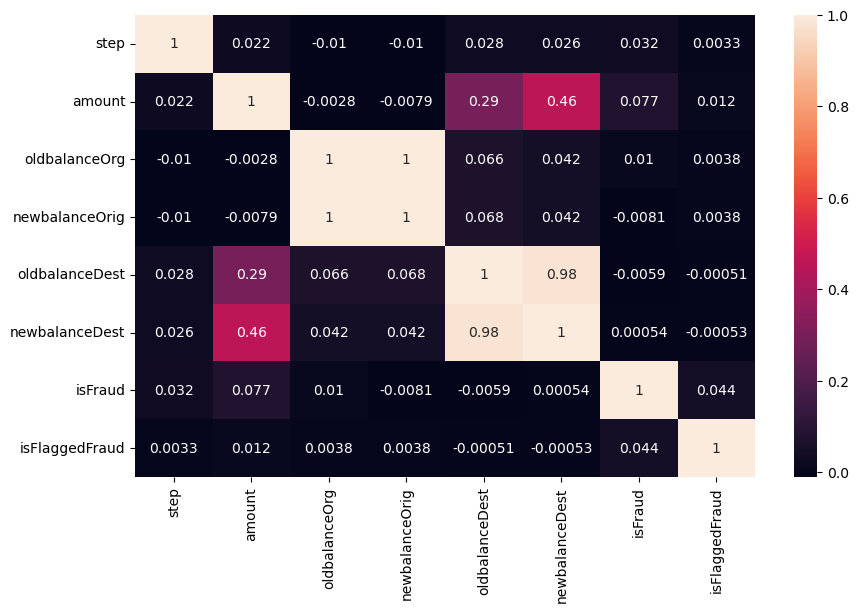

In [26]:
#Correlation heatmap
corr=df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

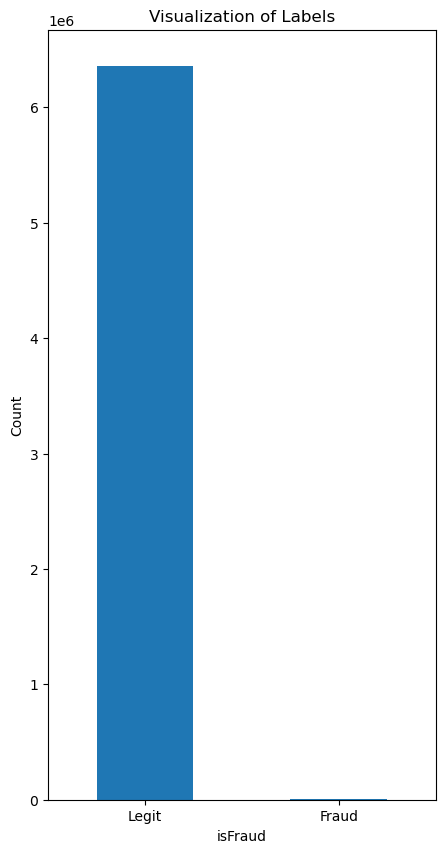

In [8]:
#number of legit and fraud transactions
plt.figure(figsize=(5,10))
labels = ["Legit", "Fraud"]
count_classes = df.value_counts(df['isFraud'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

In [9]:
#creating a copy of original dataset to train and test models

new_df=df.copy()
new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [10]:
#Label Encoding
# Checking how many attributes are dtype: object

objList = new_df.select_dtypes(include = "object").columns
print (objList)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


In [11]:
le = LabelEncoder()

for feat in objList:
    new_df[feat] = le.fit_transform(new_df[feat].astype(str))

print (new_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   nameOrig        int32  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int32  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int32(3), int64(3)
memory usage: 461.2 MB
None


In [12]:
# Multicolinearity
# Import library for VIF (VARIANCE INFLATION FACTOR)

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

calc_vif(new_df)

,variables,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


In [13]:
new_df['Actual_amount_orig'] = new_df.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
new_df['Actual_amount_dest'] = new_df.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
new_df['TransactionPath'] = new_df.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

#Dropping columns
new_df = new_df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

calc_vif(new_df)

,variables,VIF
0,type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,Actual_amount_orig,1.307910
5,Actual_amount_dest,3.754335
6,TransactionPath,2.677167


<AxesSubplot:>

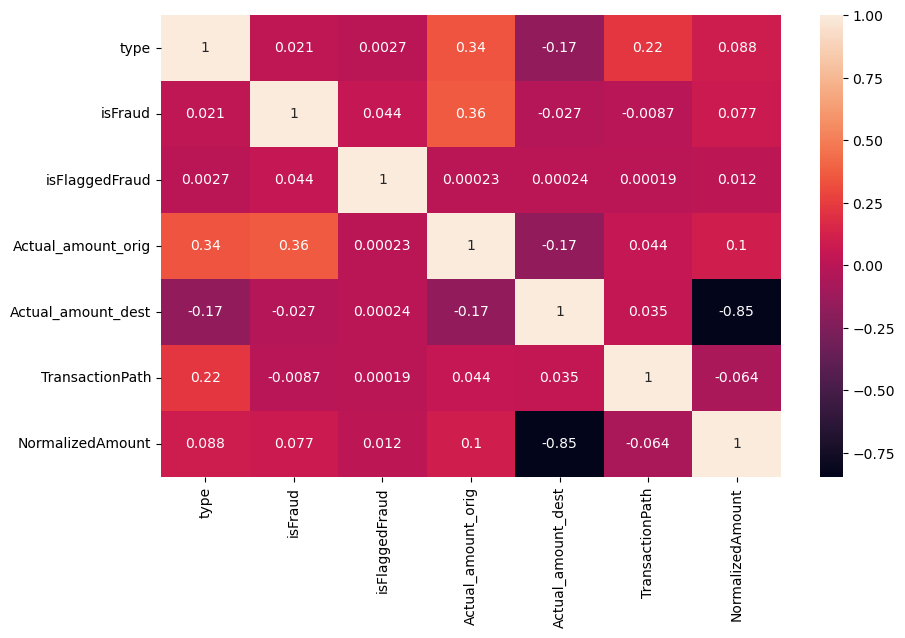

In [27]:
corr=new_df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

In [15]:
#Normalizing (scaling) amount
# Perform Scaling
scaler = StandardScaler()
new_df["NormalizedAmount"] = scaler.fit_transform(new_df["amount"].values.reshape(-1, 1))
new_df.drop(["amount"], inplace= True, axis= 1)

Y = new_df["isFraud"]
X = new_df.drop(["isFraud"], axis= 1)

In [16]:
#TRAIN-TEST SPLIT
# Split the data
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.3, random_state= 42)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (4453834, 6)
Shape of X_test:  (1908786, 6)


In [17]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred_dt = decision_tree.predict(X_test)
decision_tree_score = decision_tree.score(X_test, Y_test) * 100

In [18]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(X_train, Y_train)

Y_pred_rf = random_forest.predict(X_test)
random_forest_score = random_forest.score(X_test, Y_test) * 100

In [19]:
# Logistic Regression

logistic_regression = LogisticRegression(class_weight='unbalanced')
logistic_regression.fit(X_train, Y_train)

Y_pred_lr = logistic_regression.predict(X_test)
logistic_regression_score = logistic_regression.score(X_test, Y_test) * 100

In [20]:
# Print scores of our classifiers

print("Decision Tree Score: ",    decision_tree_score)
print("Random Forest Score: ",    random_forest_score)
print("Logistic Regression Score", logistic_regression_score)

Decision Tree Score:  99.92293531071581
Random Forest Score:  99.95871721607347
Logistic Regression Score 99.8032781045125


In [21]:
# key terms of Confusion Matrix - DT(Decision Tree)

print("TP,FP,TN,FN - Decision Tree")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_dt).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("_______________________________________________________________________________________________")

# key terms of Confusion Matrix - RF(Random Forest)

print("TP,FP,TN,FN - Random Forest")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_rf).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("_______________________________________________________________________________________________")

# key terms of Confusion Matrix - LR(Logistic Regression)

print("TP,FP,TN,FN - Logistic Regression")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_lr).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

TP,FP,TN,FN - Decision Tree
True Positives: 1717
False Positives: 753
True Negatives: 1905598
False Negatives: 718
_______________________________________________________________________________________________
TP,FP,TN,FN - Random Forest
True Positives: 1712
False Positives: 65
True Negatives: 1906286
False Negatives: 723
_______________________________________________________________________________________________
TP,FP,TN,FN - Logistic Regression
True Positives: 921
False Positives: 2241
True Negatives: 1904110
False Negatives: 1514


In [22]:
# confusion matrix - DT(Decision Tree)

confusion_matrix_dt = confusion_matrix(Y_test, Y_pred_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt,)

print("_______________________________________________________________________________________________")

# confusion matrix - RF(Random Forest)

confusion_matrix_rf = confusion_matrix(Y_test, Y_pred_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)

print("_______________________________________________________________________________________________")

# confusion matrix - LR(Logistic Regression)

confusion_matrix_lr = confusion_matrix(Y_test, Y_pred_lr.round())
print("Confusion Matrix - Logistic Regression")
print(confusion_matrix_lr)

Confusion Matrix - Decision Tree
[[1905598     753]
 [    718    1717]]
_______________________________________________________________________________________________
Confusion Matrix - Random Forest
[[1906286      65]
 [    723    1712]]
_______________________________________________________________________________________________
Confusion Matrix - Logistic Regression
[[1904110    2241]
 [   1514     921]]


In [23]:
# classification report - DT(Decision Tree)

classification_report_dt = classification_report(Y_test, Y_pred_dt)
print("Classification Report - Decision Tree")
print(classification_report_dt)

print("_______________________________________________________________________________________________")

# classification report - RF(Random Forest)

classification_report_rf = classification_report(Y_test, Y_pred_rf)
print("Classification Report - Random Forest")
print(classification_report_rf)

print("_______________________________________________________________________________________________")

# classification report - LR(Logistic Regression)

classification_report_lr = classification_report(Y_test, Y_pred_lr)
print("Classification Report - Logistic Regression")
print(classification_report_lr)

Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.70      0.71      0.70      2435

    accuracy                           1.00   1908786
   macro avg       0.85      0.85      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786

_______________________________________________________________________________________________
Classification Report - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.96      0.70      0.81      2435

    accuracy                           1.00   1908786
   macro avg       0.98      0.85      0.91   1908786
weighted avg       1.00      1.00      1.00   1908786

_______________________________________________________________________________________________
Classification Report - Logistic Regression
              precision    recall 

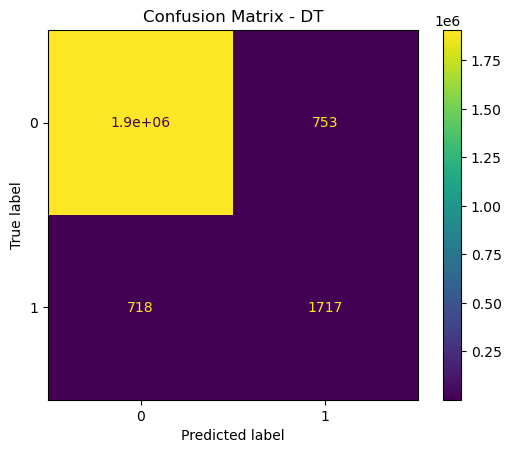

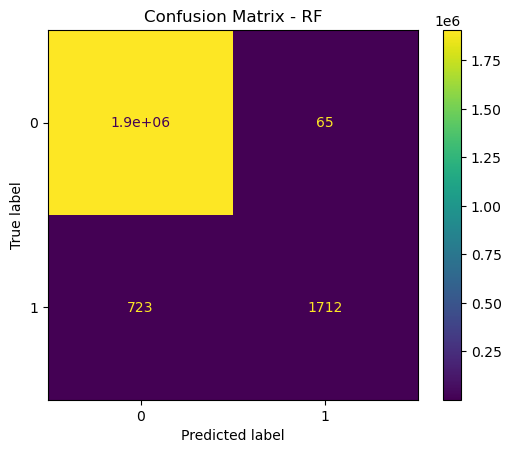

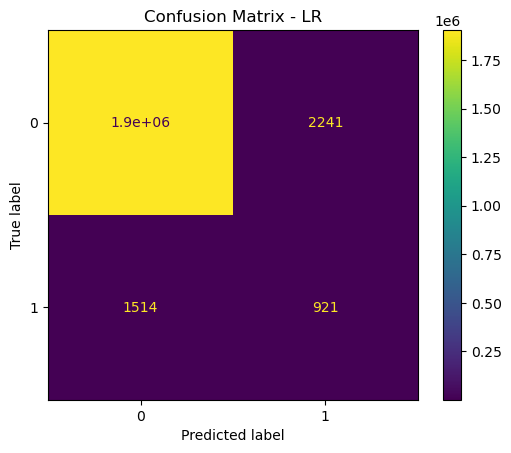

In [24]:
# visualising confusion matrix - DT(Decision Tree)


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt)
disp.plot()
plt.title('Confusion Matrix - DT')
plt.show()

# visualising confusion matrix - RF(Random Forest)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf)
disp.plot()
plt.title('Confusion Matrix - RF')
plt.show()

# visualising confusion matrix - LR(Logistic Regression)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_lr)
disp.plot()
plt.title('Confusion Matrix - LR')
plt.show()

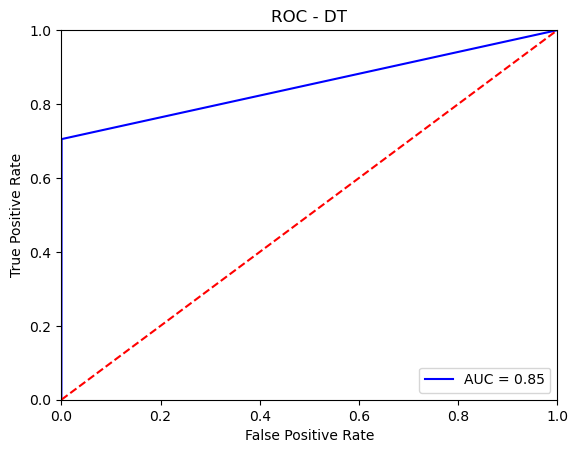

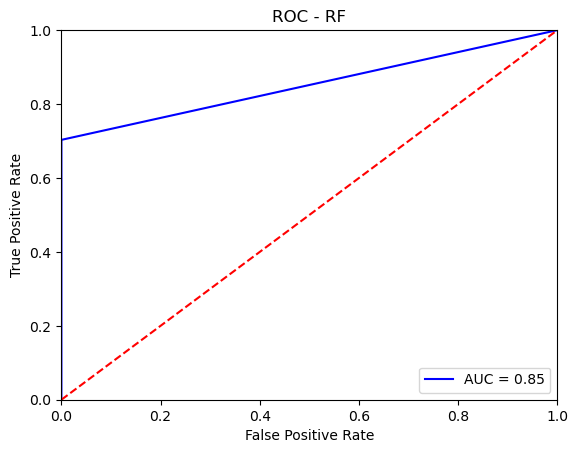

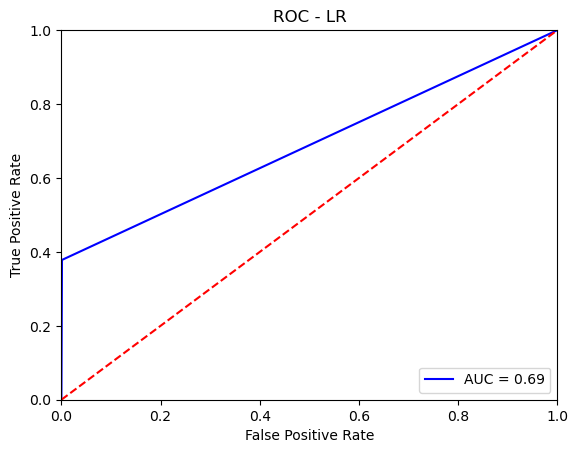

In [25]:
# AUC ROC - DT(Decision Tree)
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_dt)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# AUC ROC - RF(Random Forest)
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_rf)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# AUC ROC - LR(Logistic Regression)
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_lr)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - LR')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()